Test code to generate a multifasta

In [64]:
import proteomics.sequence as sequence
import urllib3
import json
import numpy as np
import collections
import CGAT.IOTools as IOTools
import CGAT.FastaIterator as FA

import pandas as pd
import os

import subprocess

from ete3 import NCBITaxa, TreeStyle
import sys

import string

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [65]:
ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

Done. Parsing...


Loading node names...
1595096 names loaded.
187640 synonyms loaded.
Loading nodes...
1595096 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /home/FILESERVER5/proteomics/tss38/.etetoolkit/taxa.sqlite ...
 1595000 generating entries...  generating entries...  354000 generating entries... 409000 generating entries... generating entries... generating entries...  generating entries...  generating entries... 648000 generating entries... 673000 generating entries... generating entries...  generating entries... generating entries...   generating entries... generating entries... generating entries... 943000 generating entries... generating entries... generating entries...   generating entries...  generating entries... generating entries...  generating entries...  1570000 generating entries... 
Uploading to /home/FILESERVER5/proteomics/tss38/.etetoolkit/taxa.sqlite


Inserting synonyms:      15000 

Inserting synonyms:      185000 

Inserting taxids:       20000  

Inserting taxids:       1595000 

In [66]:
tetrapod_tax_id = 32523
vertebrate_tax_id = 7742
mammals_tax_id = 40674
placentals_tax_id = 9347
rodent_tax_id = 9989
eukaryote_tax_id = 2759

mouse_tax_id = 10090

In [67]:
print(ncbi.get_common_names([10090]))

{10090: 'house mouse'}


In [68]:
OGs_inf = "../raw/odb9v1_OGs_corrected.tab"
OG2genes_inf = "../raw/odb9v1_OG2genes.tab.gz"
genes_inf = "../raw/odb9v1_genes.tab"


In [69]:
uniprot_ids = []
outfile = "./results/multifasta.fa"
outfile_aligned = "./results/multifasta_clustalo.fa"


In [70]:
tax_id = vertebrate_tax_id
#tax_id = eukaryote_tax_id

groups = set()
with IOTools.openFile(OGs_inf, "r") as inf:
    for line in inf:
        group, tax_level = line.strip().split("\t")[0:2]
        if tax_level == str(tax_id):
            groups.add(group)
        
print(len(groups))

      
    

37682


In [71]:
first_group = list(groups)

[0]

group2genes = collections.defaultdict(list)
gene2groups = collections.defaultdict(list)

with IOTools.openFile(OG2genes_inf, "r") as inf:
    for line in inf:
        group, gene = line.strip().split("\t")
        if group in groups:
            group2genes[group].append(gene)
            gene2groups[gene].append(group)
            

print(line)
print(len(group2genes))
print(len(gene2groups))

VOG090F000Z	282063:000001

37682
2885566


In [72]:
gene2uniprot = {}
uniprot2gene = collections.defaultdict(list)
with IOTools.openFile(genes_inf) as inf:
    for line in inf:
        gene, uniprot = line.strip().split("\t")[2:4]
        if gene not in gene2groups:
            continue
        if gene in gene2uniprot:
            print(gene, uniprot, gene2uniprot[gene])
            break
        gene2uniprot[gene] = uniprot
        uniprot2gene[uniprot].append(gene)

print(len(gene2uniprot))
print(len(uniprot2gene))

2885566
849831


In [73]:
ratio_df = pd.read_table("./results/ratio_df.tsv", sep="\t")
print(ratio_df.shape)
#ratio_df =  ratio_df[ratio_df['reference']=='Park_et_al_2013']
print(ratio_df.shape)
print(collections.Counter(ratio_df['modification']))
ratio_df = ratio_df[ratio_df['modification'].isin(['succinylation', 'malonylation'])]
print(ratio_df.shape)
ratio_df = ratio_df[ratio_df['ratio']!=-1]
print(ratio_df.shape)

print(ratio_df.sort_values('ratio', ascending=False).head(30))
uniprot_ids = set(ratio_df.sort_values('ratio', ascending=False).head(30)['uniprot_id'])
print(uniprot_ids)

(12884, 11)
(12884, 11)
Counter({'acetylation': 4789, 'malonylation': 4363, 'succinylation': 3644, 'succinylation_SIRT5_KO': 88})
(8007, 11)
(2844, 11)
      uniprot_id  position   modification             reference       ratio  \
7358      Q8BMS1       406  succinylation  Sadhukhan_et_al_2016  522.600000   
11344     Q9DB20        97  succinylation     Rardin_et_al_2013  395.260000   
7736      Q8C196      1486  succinylation     Rardin_et_al_2013  305.430000   
7601      Q8BWT1       214  succinylation     Rardin_et_al_2013  179.460000   
9072      Q91VA0       534  succinylation     Rardin_et_al_2013  178.100000   
962       P08249       239  succinylation     Rardin_et_al_2013  157.590000   
3298      P42125       283  succinylation     Rardin_et_al_2013  141.330000   
5889      Q3V3R1       595  succinylation       Park_et_al_2013  118.765772   
3633      P48962       147  succinylation       Park_et_al_2013  110.686120   
8445      Q8QZT1       171  succinylation  Sadhukhan_et_al

In [74]:
uniprot_ids = set(ratio_df['uniprot_id'])
print(len(uniprot_ids))

685


In [75]:
split_at = 60

uniprot_ids = set(ratio_df['uniprot_id'])
print(len(uniprot_ids))
n = 0
for uniprot_id in uniprot_ids:
    
    if n % 50 ==0:
        print("completed %i proteins" % n)
    n+=1
    
    #print("\n", uniprot_id)
    genes = uniprot2gene[uniprot_id]
    if len(genes) == 0:
        print("no groups")
        continue
        
    groups = gene2groups[genes[0]]
    group_genes = group2genes[groups[0]]
    group_uniprot_ids = [gene2uniprot[x] for x in group_genes]
    

    fasta_entries = []
    for values in sequence.getSequences([x for x in group_uniprot_ids if x!="\\N"]):
        fasta_entries.append(values)

    mouse_ix = None
    group_fasta_outfile = "./results/conservation/fasta/%s_multifasta.fa" % uniprot_id
    
    tax_ids = set()
    with IOTools.openFile(group_fasta_outfile, "w") as outf:
        for ix, entry in enumerate(fasta_entries):
            acc, taxid, seq, ebi_api = entry
            tax_ids.add(taxid)
            if taxid == int(mouse_tax_id) and acc == uniprot_id:
                split_seq = [seq[i:i+split_at] for i in range(0, len(seq), split_at)]
                outf.write(">%s_%s\n%s\n" % (acc, taxid, "\n".join(split_seq)))
                mouse_ix = ix

        assert mouse_ix is not None, "mouse protein not found! %i %i %s!" % (
            10090 in tax_ids, len(group_uniprot_ids), uniprot_id)

        for ix, entry in enumerate(fasta_entries):
            acc, taxid, seq, ebi_api = entry
            if ix != mouse_ix:
                try:
                    split_seq = [seq[i:i+split_at] for i in range(0, len(seq), split_at)]
                    outf.write(">%s_%s\n%s\n" % (acc, taxid, "\n".join(split_seq)))
                except:
                    pass

                #print(entry)
print("completed %i proteins" % n)

685
completed 0 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 50 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 100 proteins
no groups
no groups
no groups
no groups
completed 150 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 200 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 250 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 300 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 350 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 400 proteins
no groups
no groups
no groups
no groups
no groups
no groups
no groups
no groups
completed 450 proteins
no groups
no groups
no groups
no groups
no groups
no groups
completed

In [76]:
print(len(group_uniprot_ids))
fasta_entries = []
for values in sequence.getSequences([x for x in group_uniprot_ids if x!="\\N"]):
    fasta_entries.append(values)

171


In [77]:
aas = [x for x in string.ascii_uppercase if x not in ["O", "J", "U", "B"]]
aas.append("-")
print(aas)

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z', '-']


In [117]:
amino_acids_at_K = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(set)))
alignments = collections.defaultdict(lambda: collections.defaultdict(str))
seqs = collections.defaultdict(str)
#tmp_df = ratio_df[ratio_df['reference']!='Sadhukhan_et_al_2016']
uniprot2_121_orthologs = collections.defaultdict(set)

species = set()
rows = []
completed = set()

for uniprot_id in set(uniprot_ids):
    outfile_aligned = "./results/conservation/fasta/%s_clustalo.fa" % uniprot_id
    if os.path.exists(outfile_aligned):
        
        possible_alignments = collections.defaultdict(set)
        mouse_seq = None
        
        for ix, fasta in enumerate(FA.iterate(IOTools.openFile(outfile_aligned, "r"))):
            tax_id_uniprot_id, tax_id = fasta.title.split("_")
            tax_id = int(tax_id.replace(";", ""))
            species.add(tax_id)
            
            if tax_id == 10090:
                if tax_id_uniprot_id == uniprot_id:
                    mouse_seq = fasta.sequence
                else:
                    continue
            else:
                possible_alignments[tax_id].add((fasta.sequence, tax_id_uniprot_id))

        assert mouse_seq is not None
        
            
            
        for tax_id in possible_alignments:
            top_distance = len(mouse_seq)
            top_seq = ""
            top_id = ""
            for seq, tax_id_uniprot_id in possible_alignments[tax_id]:
                distance = sum([x!=y for x, y in zip(seq, mouse_seq)])
                if distance < top_distance:
                    top_distance = distance
                    top_seq = seq
                    top_id = tax_id_uniprot_id

            uniprot2_121_orthologs[uniprot_id].add(top_id)
      
        
        positions = set(ratio_df[ratio_df['uniprot_id']==uniprot_id]['position'].tolist())
        
        for position in positions:
            possible_alignments = collections.defaultdict(set)
            amino_acids = []
            row = [uniprot_id, position]
            gaps = 0
            for fasta in FA.iterate(IOTools.openFile(outfile_aligned, "r")):
                tax_id_uniprot_id, tax_id = fasta.title.split("_")
                tax_id = int(tax_id.replace(";", ""))

                if tax_id == 10090:
                    if tax_id_uniprot_id == uniprot_id:
                        seq_n = 0
                        align_n = 0
                        for align_position in fasta.sequence.replace(" ", ""):

                            if align_position != "-":
                                seq_n+=1
                                if seq_n == position:
                                    break
                            else:
                                gaps += 1
                            align_n += 1

                        mouse_seq = fasta.sequence[align_n-11:align_n+11]
                        alignments[uniprot_id][position] += ">%s\n%s\n" % (tax_id,mouse_seq)
                        try:
                            amino_acids.append(fasta.sequence[align_n])
                        except:
                            print(len(fasta.sequence))
                            print(align_n)
                            print(positions)
                            print(position)
                            print(uniprot_id)
                            print(ratio_df[ratio_df['uniprot_id']==uniprot_id])
                            raise ValueError()
                        amino_acids_at_K[uniprot_id][position][fasta.sequence[align_n]].add(tax_id)

                elif tax_id_uniprot_id in uniprot2_121_orthologs[uniprot_id]:
                    top_seq = fasta.sequence[align_n-11:align_n+11]
                    alignments[uniprot_id][position] += ">%s\n%s\n" % (
                        tax_id, top_seq)
                    amino_acids_at_K[uniprot_id][position][fasta.sequence[align_n]].add(tax_id)
                    amino_acids.append(fasta.sequence[align_n])

            #remove the final newlines from alignments
            alignments[uniprot_id][position] = alignments[uniprot_id][position].strip()

            row.append(len(amino_acids))
            for aa in aas:
                row.append(amino_acids.count(aa))

            rows.append(row)

            alignment_tax_ids = collections.Counter()

            for line in alignments[uniprot_id][position].split("\n"):
                if line.startswith(">"):
                    alignment_tax_ids[int(line[1:])] += 1


In [118]:
print(len(alignments))
print(len(species))

387
149


In [174]:
header = ["uniprot_id", "position", "total"]
header.extend(aas)
header[-1] = "missing"
base_counts_df = pd.DataFrame.from_records(rows, columns=header)

base_counts_df = pd.merge(base_counts_df, ratio_df,
                          left_on=["uniprot_id", "position"],
                          right_on=["uniprot_id", "position"],
                          how='left')
base_counts_df['short_ref'] = [x.split("_")[0] for x in base_counts_df.reference]
print(base_counts_df.head())
print(base_counts_df.shape)
base_counts_df.drop("in_elm", inplace=True, axis=1)

  uniprot_id  position  total  A  C  D  E  F  G  H    ...       modification  \
0     P30681       128     49  0  0  0  0  0  0  0    ...      succinylation   
1     Q91YQ5       539     45  0  0  0  0  0  0  0    ...       malonylation   
2     Q91YQ5       188     45  0  0  0  0  0  0  0    ...      succinylation   
3     Q91YQ5       580     45  0  0  0  0  0  0  0    ...       malonylation   
4     Q922Q1        97     46  1  0  0  1  0  0  0    ...       malonylation   

            reference     ratio  p_value  in_idr  in_nls  in_krepeats  \
0     Park_et_al_2013  2.523623 -1.00000    True   False         True   
1  Nishida_et_al_2015  1.905024  0.00012   False   False        False   
2     Park_et_al_2013  1.392716 -1.00000   False   False        False   
3  Nishida_et_al_2015  1.154800  0.46000   False   False         True   
4  Nishida_et_al_2015  0.724286  0.11900   False   False        False   

   len_repeats  in_elm  short_ref  
0            2     NaN       Park  
1       

In [175]:
results_dir = "./results/"
raw_dir = "../raw"
lysine_mod_inf = os.path.join(results_dir, 'lysine_modification.tsv')

cadherin_inf = os.path.join(results_dir, "cadherine_proteins.tsv")
cadherin_glass_inf = os.path.join(results_dir, "ecadherin_glass.tsv")
cadherin_biotin_inf = os.path.join(results_dir, "ecadherin_biotin.tsv")

def readCadherin(infile, column_name, abundance_column=None, sep=","):
    df = pd.read_table(infile, sep=sep)
    df[column_name] = 1
    df = df[df['Mouse_uniprot_IDs'].notnull()]

    if abundance_column:
        df = df[['Mouse_uniprot_IDs', column_name, abundance_column]]
    else:
        df = df[['Mouse_uniprot_IDs', column_name]]
    df.set_index('Mouse_uniprot_IDs', inplace=True)

    return df
    
cadherin_interactome_df  = readCadherin(
    cadherin_inf, "cadherin_interactome", sep=",")
ecadherin_glass_interactome_df = readCadherin(
    cadherin_glass_inf, "ecadherin_glass_interactome", "interactome_abundance",)
ecadherin_biotin_interactome_df = readCadherin(
    cadherin_biotin_inf, "ecadherin_biotin_interactome", "interactome_abundance")

ecadherin_glass_interactome_df.rename(
    columns={'interactome_abundance':'glass_interactome_abundance'}, inplace=True)
ecadherin_biotin_interactome_df.rename(
    columns={'interactome_abundance':'biotin_interactome_abundance'}, inplace=True)

ecadherin_biotin_interactome_df['biotin_rank'] = ecadherin_biotin_interactome_df[
    'biotin_interactome_abundance'].rank(ascending=False)
ecadherin_glass_interactome_df['glass_rank'] = ecadherin_glass_interactome_df[
    'glass_interactome_abundance'].rank(ascending=False)

print(ecadherin_biotin_interactome_df.head())
print(ecadherin_glass_interactome_df.head())
print(cadherin_interactome_df.head())



                      ecadherin_biotin_interactome  \
Mouse_uniprot_IDs                                    
P26231;Q65CL1                                    1   
Q02257                                           1   
Q8CBD1                                           1   
P62751                                           1   
P62984;P0CG50;P62983                             1   

                      biotin_interactome_abundance  biotin_rank  
Mouse_uniprot_IDs                                                
P26231;Q65CL1                            14.231545          1.0  
Q02257                                   12.680877          2.0  
Q8CBD1                                   12.531690          3.0  
P62751                                    8.834130          4.0  
P62984;P0CG50;P62983                      3.883620          5.0  
                   ecadherin_glass_interactome  glass_interactome_abundance  \
Mouse_uniprot_IDs                                                             
P

In [288]:
print(base_counts_df.shape)
base_counts_interactome_df = pd.merge(base_counts_df, cadherin_interactome_df,
                          left_on='uniprot_id', right_index=True, how="left")
base_counts_interactome_df = pd.merge(base_counts_interactome_df, ecadherin_biotin_interactome_df,
                          left_on='uniprot_id', right_index=True, how="left")
base_counts_interactome_df = pd.merge(base_counts_interactome_df, ecadherin_glass_interactome_df,
                          left_on='uniprot_id', right_index=True, how="left")
base_counts_interactome_df['any_interactome'] = base_counts_interactome_df[[
    "cadherin_interactome", "ecadherin_biotin_interactome",
    "ecadherin_glass_interactome"]].apply(np.max, axis=1)

#print(base_counts_interactome_df[[
#    "cadherin_interactome", "ecadherin_biotin_interactome", "ecadherin_glass_interactome"]].apply(anyInteraction, axis=1))
#base_counts_interactome_df['any_interactome'] = base_counts_interactome_df[[
#    "cadherin_interactome", "ecadherin_biotin_interactome", "ecadherin_glass_interactome"]].apply(np.nanmax)
    #lambda x: np.max(x, ignore_na=True))

base_counts_interactome_df.fillna(0)
print(base_counts_interactome_df.shape)
print(base_counts_interactome_df.head())
print(base_counts_interactome_df[base_counts_interactome_df['cadherin_interactome']==1.0].head(3))


(2046, 35)
(2046, 43)
  uniprot_id  position  total  A  C  D  E  F  G  H       ...         \
0     P30681       128     49  0  0  0  0  0  0  0       ...          
1     Q91YQ5       539     45  0  0  0  0  0  0  0       ...          
2     Q91YQ5       188     45  0  0  0  0  0  0  0       ...          
3     Q91YQ5       580     45  0  0  0  0  0  0  0       ...          
4     Q922Q1        97     46  1  0  0  1  0  0  0       ...          

   len_repeats  short_ref  cadherin_interactome  ecadherin_biotin_interactome  \
0            2       Park                   NaN                           NaN   
1            1    Nishida                   NaN                           NaN   
2            1       Park                   NaN                           NaN   
3            2    Nishida                   NaN                           NaN   
4            1    Nishida                   NaN                           NaN   

   biotin_interactome_abundance  biotin_rank  ecadherin_glass_in

In [289]:
%%R
library(ggbeeswarm)

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


  uniprot_id position total A C D E F G H I  K L M N P Q R S  T V W X Y Z
0     P30681      128    49 0 0 0 0 0 0 0 0 46 0 0 0 0 0 3 0  0 0 0 0 0 0
1     Q91YQ5      539    45 0 0 0 0 0 0 0 0 45 0 0 0 0 0 0 0  0 0 0 0 0 0
2     Q91YQ5      188    45 0 0 0 0 0 0 0 0 44 0 0 0 0 0 0 0  0 0 0 0 0 0
3     Q91YQ5      580    45 0 0 0 0 0 0 0 0 44 0 0 0 0 0 0 0  0 0 0 0 0 0
4     Q922Q1       97    46 1 0 0 1 0 0 0 0 23 0 0 2 0 1 3 1 11 0 0 0 0 0
5     Q922Q1       66    46 0 0 0 0 0 1 0 0 37 0 0 0 0 0 0 0  0 0 0 0 0 0
  missing  modification          reference     ratio  p_value in_idr in_nls
0       0 succinylation    Park_et_al_2013 2.5236227 -1.00000   TRUE  FALSE
1       0  malonylation Nishida_et_al_2015 1.9050244  0.00012  FALSE  FALSE
2       1 succinylation    Park_et_al_2013 1.3927157 -1.00000  FALSE  FALSE
3       1  malonylation Nishida_et_al_2015 1.1547999  0.46000  FALSE  FALSE
4       3  malonylation Nishida_et_al_2015 0.7242859  0.11900  FALSE  FALSE
5       8  malonylation Ni

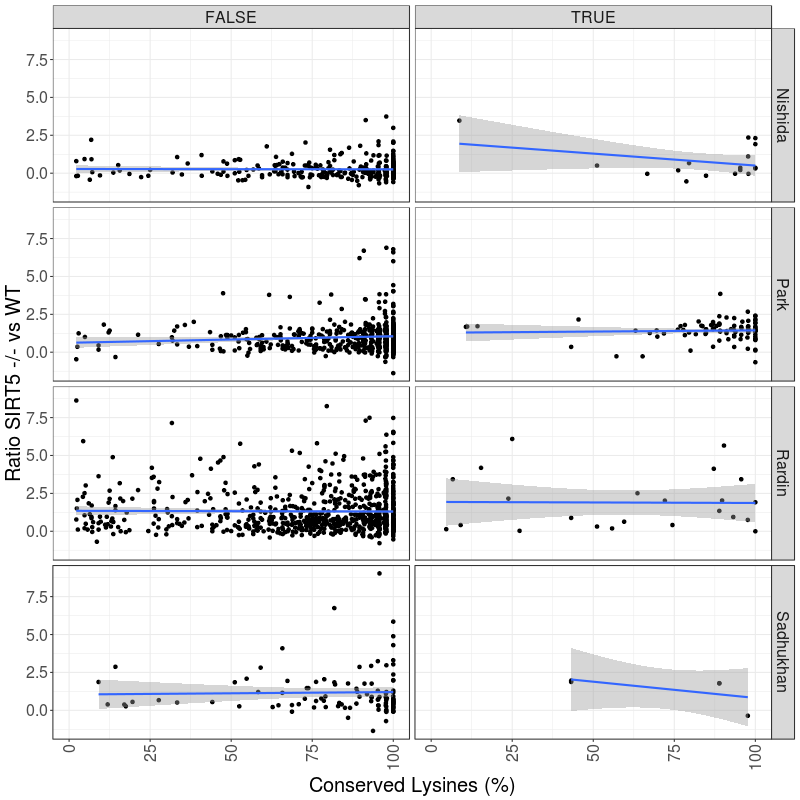

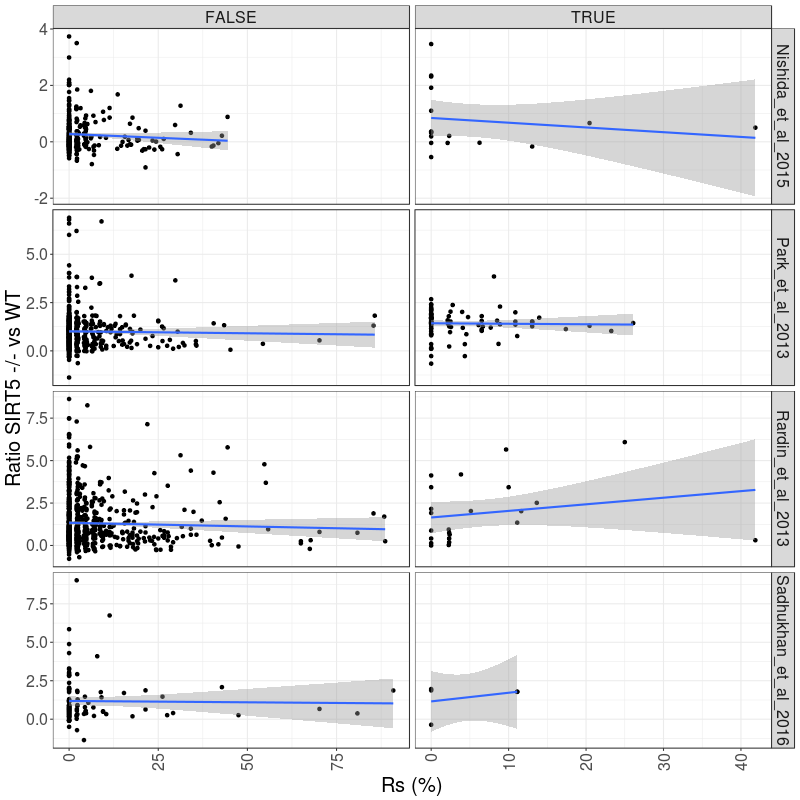

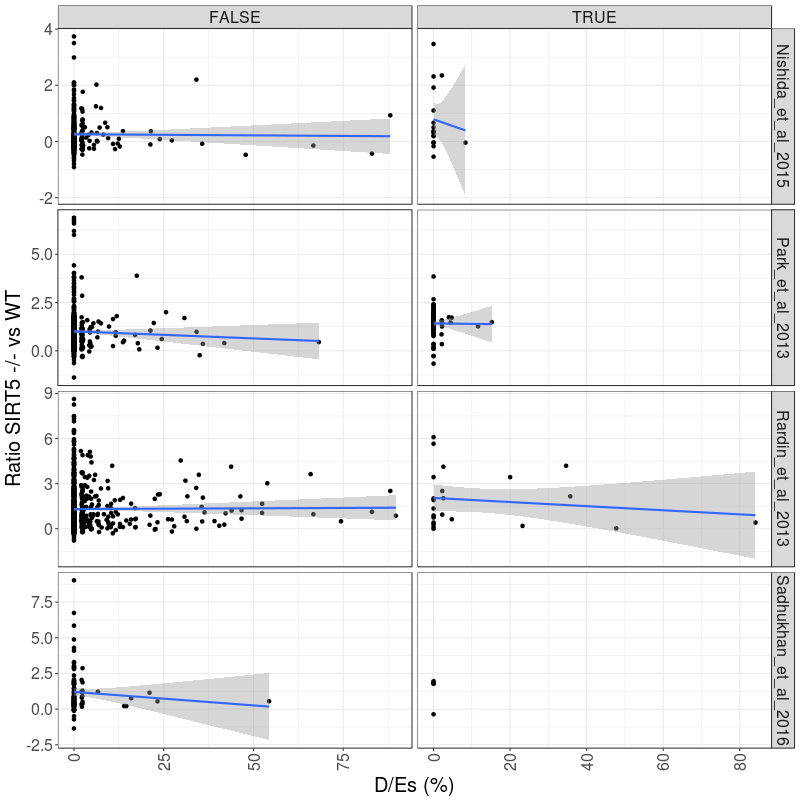

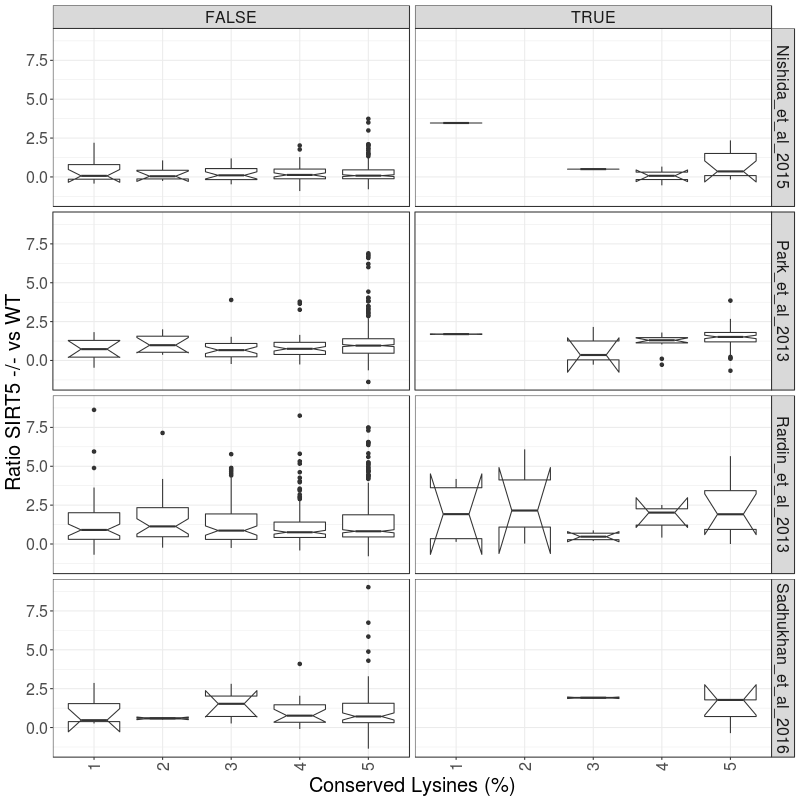

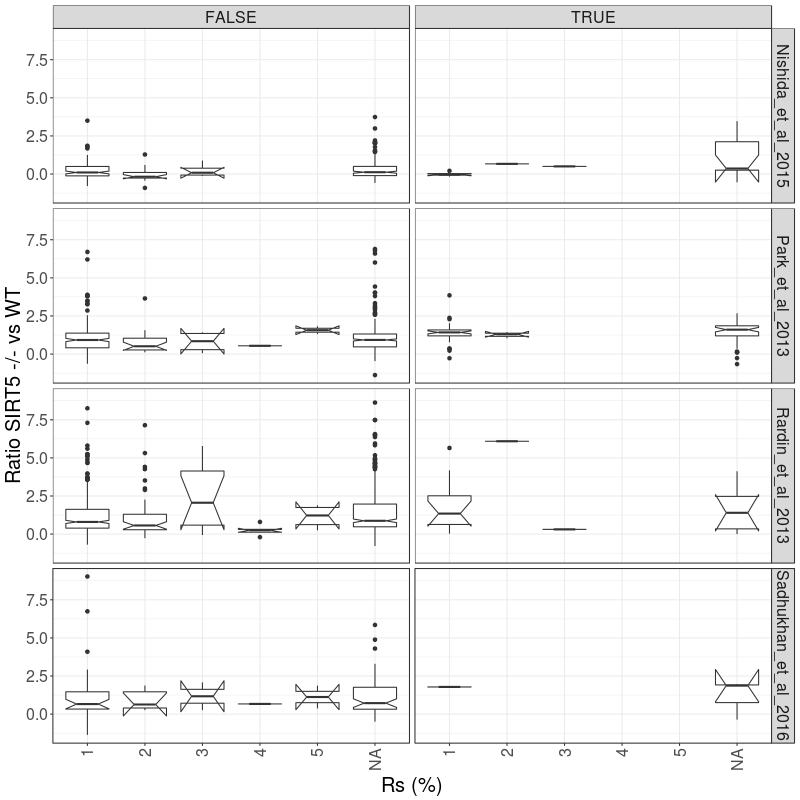

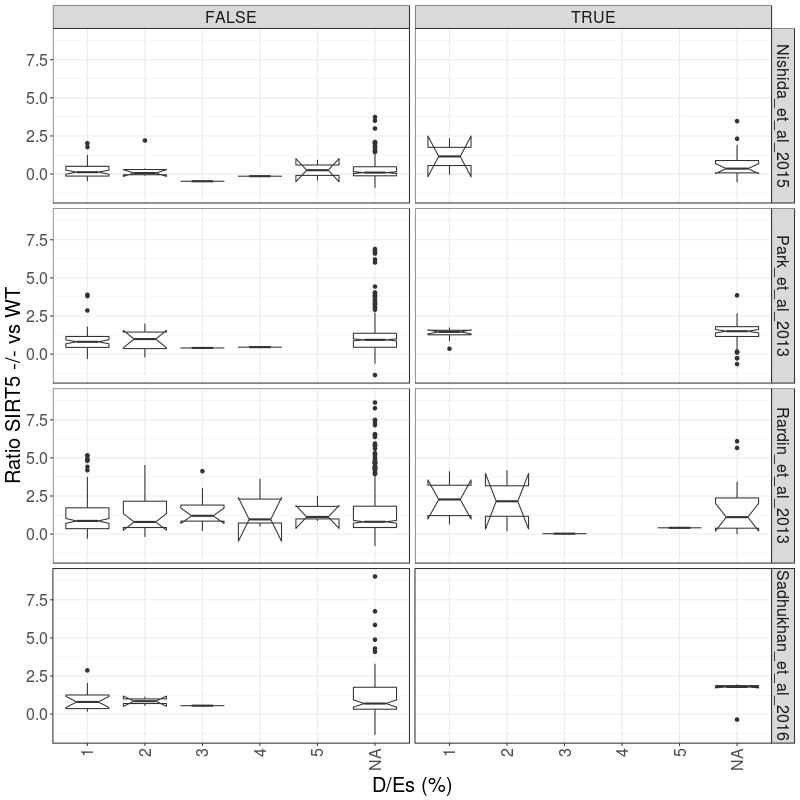

In [290]:
%%R -i base_counts_interactome_df -w 800 -h 800

base_counts_df <- base_counts_interactome_df

library(ggplot2)

base_counts_df$ratio <- as.numeric(as.character(base_counts_df$ratio))

base_counts_df$K_conservation = (100*base_counts_df$K) / (base_counts_df$total - base_counts_df$missing)
base_counts_df$R_conversion = (100*base_counts_df$R) / (base_counts_df$total - base_counts_df$missing)
base_counts_df$DE_conversion = (100*(base_counts_df$D + base_counts_df$E) /
                 (base_counts_df$total - base_counts_df$missing))
base_counts_df$binned_K_conservation <- .bincode(base_counts_df$K_conservation, breaks = seq(0,100,20))
base_counts_df$binned_DE_conservation <- .bincode(base_counts_df$DE_conversion, breaks = seq(0,100,20))
base_counts_df$binned_R_conservation <- .bincode(base_counts_df$R_conversion, breaks = seq(0,100,20))

print(head(base_counts_df))

m_txt <- element_text(size=20)
my_theme <- theme(
    text=m_txt,
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

p <- ggplot(base_counts_df, aes(K_conservation, log(ratio,2))) +
geom_point() + geom_smooth(method="lm") +
facet_grid(short_ref~in_idr) +
theme_bw() +
xlab("Conserved Lysines (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(R_conversion, log(ratio,2))) +
geom_point() + geom_smooth(method="lm") +
facet_grid(reference~in_idr, scales='free') +
theme_bw() +
xlab("Rs (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(DE_conversion, log(ratio,2))) +
geom_point() + geom_smooth(method="lm") +
facet_grid(reference~in_idr, scales='free') +
theme_bw() +
xlab("D/Es (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(factor(binned_K_conservation), log(ratio,2))) +
geom_boxplot(notch=TRUE) +
facet_grid(reference~in_idr) +
theme_bw() +
xlab("Conserved Lysines (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)

p <- ggplot(base_counts_df, aes(factor(binned_R_conservation), log(ratio,2))) +
geom_boxplot(notch=TRUE) +
facet_grid(reference~in_idr) +
theme_bw() +
xlab("Rs (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)
p <- ggplot(base_counts_df, aes(factor(binned_DE_conservation), log(ratio,2))) +
geom_boxplot(notch=TRUE) +
facet_grid(reference~in_idr) +
theme_bw() +
xlab("D/Es (%)") +
ylab("Ratio SIRT5 -/- vs WT") +
#scale_x_continuous(breaks=seq(0,100,25), limits=c(0,100)) +
my_theme

print(p)


       
        FALSE TRUE
  FALSE   247   84
  TRUE    240  158
       
        FALSE TRUE
  FALSE   322    9
  TRUE    396    2
       
        FALSE TRUE
  FALSE   314   17
  TRUE    385   13


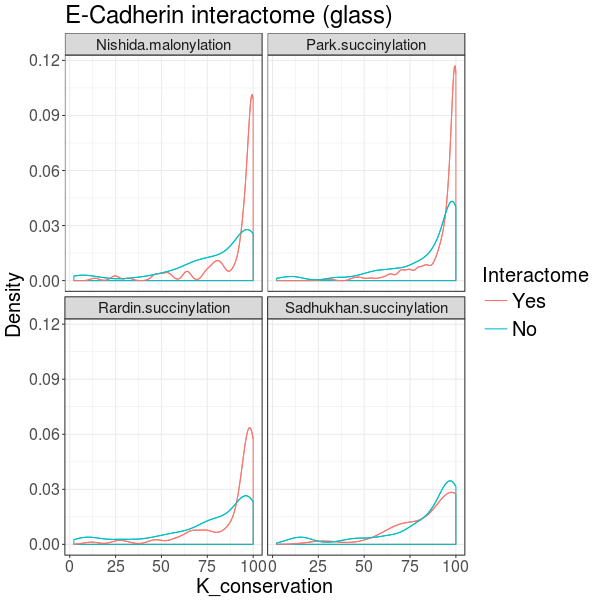

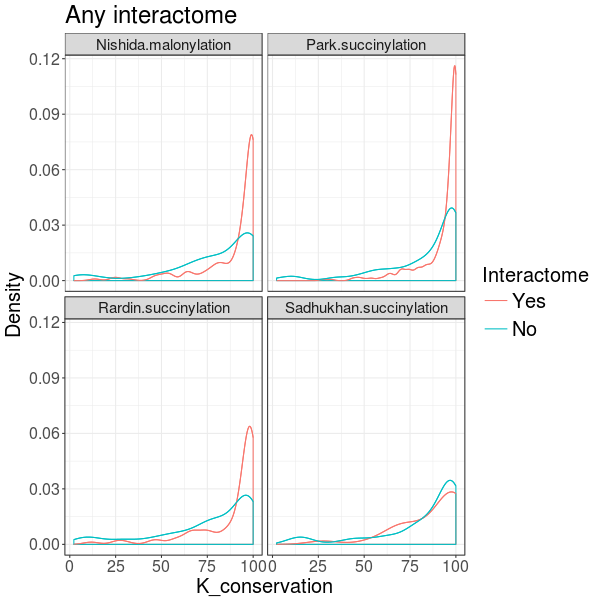

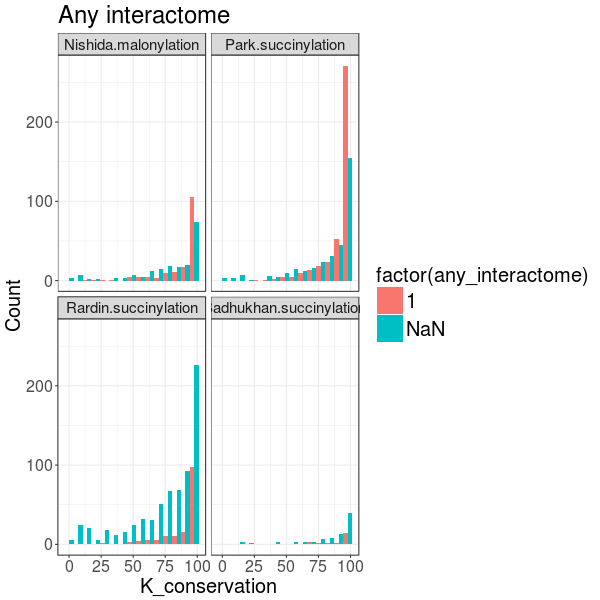

In [307]:
%%R -w 600 -h 600
m_txt = element_text(size=20)
s_txt = element_text(size=15)
#print(head(base_counts_df))
#p = ggplot(base_counts_df[base_counts_df['short_ref']=='Park',]) +
p = ggplot(base_counts_df) +
facet_wrap(~interaction(short_ref, modification)) +
scale_colour_discrete(name="Interactome", label=c("Yes","No"),
                      guide = guide_legend(override.aes=aes(fill=NA))) +
theme_bw() +
ylab("Density") +
theme(
    text=m_txt,
    strip.text=s_txt,
    legend.text=m_txt,
    legend.key.size=unit(1, "cm"))

pK = p + aes(K_conservation)
pDE = p + aes(DE_conversion)
pR = p + aes(R_conversion)

pK1 = pK + geom_density(aes(colour=factor(cadherin_interactome)), show_guide=F) +
stat_density(aes(colour=factor(cadherin_interactome)),
             geom="line",position="identity") +
ggtitle("Cadherin interactome")

pK2 = pK + geom_density(aes(colour=factor(ecadherin_biotin_interactome)), show_guide=F) +
stat_density(aes(colour=factor(ecadherin_biotin_interactome)),
                   geom="line",position="identity") +
ggtitle("E-Cadherin interactomen(biotin)")

pK3 = pK + geom_density(
    aes(colour=interaction(factor(ecadherin_glass_interactome))),
        show_guide=F) +
stat_density(aes(colour=factor(ecadherin_glass_interactome)),
                   geom="line",position="identity") +
ggtitle("E-Cadherin interactome (glass)")
ggsave("../plots.dir/e_cadherin_interactome_glass_K_conservation.png")


pK4 = pK + geom_density(aes(colour=factor(any_interactome)), show_guide=F) +
stat_density(aes(colour=factor(any_interactome)),
             geom="line",position="identity") +
ggtitle("Any interactome")

pK5 = pK + geom_histogram(aes(fill=factor(any_interactome)), position="dodge", bins=15) +
ggtitle("Any interactome") + ylab("Count")


pDE3 = pDE + geom_density(aes(colour=factor(ecadherin_glass_interactome)), show_guide=F) +
stat_density(aes(colour=factor(ecadherin_glass_interactome)),
                   geom="line",position="identity") +
ggtitle("E-Cadherin interactome (glass)")

pR3 = pR + geom_density(aes(colour=factor(ecadherin_glass_interactome)), show_guide=F) +
stat_density(aes(colour=factor(ecadherin_glass_interactome)),
                   geom="line",position="identity") +
ggtitle("E-Cadherin interactome (glass)")


pDE4 = pDE + geom_density(aes(colour=factor(any_interactome)), show_guide=F) +
stat_density(aes(colour=factor(any_interactome)),
             geom="line",position="identity") +
ggtitle("Any interactome")


#print(pK1)
#print(pK2)
print(pK3)
print(pK4)
print(pK5)
#print(pDE3)
#print(pDE4)
#print(pR3)

tmp_df <- base_counts_df[base_counts_df['short_ref']=='Park',]
print(table(is.finite(tmp_df[['any_interactome']]), factor(tmp_df[['K_conservation']]==100)))
print(table(is.finite(tmp_df[['any_interactome']]), factor(tmp_df[['DE_conversion']]>20)))
print(table(is.finite(tmp_df[['any_interactome']]), factor(tmp_df[['R_conversion']]>20)))



In [84]:
def isInGroup(tax_id, group):
    '''unfortunately yhe ncbi.get_descendant function from ete doesn't
    retrieve all descendants. For example 9606 (homo sapien) is not in vertebrates!
    
    This function tests if the group is in the tax_id lineage'''
    return group in ncbi.get_lineage(tax_id)

print(isInGroup(9606, vertebrate_tax_id))
print(isInGroup(9606, mammals_tax_id))
print(isInGroup(9606, placentals_tax_id))
print(isInGroup(28377, vertebrate_tax_id)) #green Anole
print(isInGroup(28377, mammals_tax_id)) #green Anole
print(isInGroup(28377, placentals_tax_id)) #green Anole

True
True
True
True
False
False


In [85]:
mammal_ids = set()
non_mammal_ids = set()

placental_ids = set()
non_placental_ids = set()

rodent_rabit_ids = set()
non_rodent_rabit_ids = set()
print(10090 in species)
print(9601 in species)
for organism in species:
    
    if isInGroup(organism, mammals_tax_id):
        mammal_ids.add(organism)
    else:
        non_mammal_ids.add(organism)
    
    if isInGroup(organism, placentals_tax_id):
        placental_ids.add(organism)
    else:
        non_placental_ids.add(organism)
        
    if isInGroup(organism, rodent_tax_id):
        rodent_rabit_ids.add(organism)
    else:
        non_rodent_rabit_ids.add(organism)
        
        
print("10090" in mammal_ids)
print("10090" in non_mammal_ids)

print("9601" in mammal_ids)
print("9601" in non_mammal_ids)


True
True
False
False
False
False


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:224: UserWarning: taxid 994 was translated into 986
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [86]:
n = 0 

rows = []

for uniprot_id in alignments.keys():
    positions_covered = set()
    #if n>=5:
    #    break
    #print(uniprot_id)
    for position in alignments[uniprot_id]:

        tmp_alignments = alignments[uniprot_id][position].split("\n")
        
        tmp_alignment_tax_ids = [x[1:] for x in tmp_alignments[::2]]
        tmp_alignment_tax_seq = [x[1:] for x in tmp_alignments[1::2]]
        tmp_alignments_dict = {int(x):y for x, y in zip(tmp_alignment_tax_ids, tmp_alignment_tax_seq)}
        
        seq_ix = -11
        for ix, base in enumerate(tmp_alignments_dict[10090], -10):
            if not base == "-":
                seq_ix += 1
            if base == "K":
                if position+ix not in positions_covered:
                    positions_covered.add(position+ix)

                    k_mammals = 0
                    k_non_mammals = 0
                    non_k_mammals = 0
                    non_k_non_mammals = 0
                    de_mammals = 0
                    de_non_mammals = 0
                    non_de_mammals = 0
                    non_de_non_mammals = 0
                    r_all = 0
                    total = 0

                    #print(tmp_alignments_dict)
                    for tax_id in tmp_alignments_dict:

                        seq = tmp_alignments_dict[tax_id]
                        mammal = tax_id in mammal_ids
                        
                        tax_id_base = seq[ix + 10]

                        try:
                            if tax_id_base == "-":
                                pass
                            else:
                                total += 1
                                if tax_id_base == "K":
                                    if mammal:
                                        k_mammals += 1
                                        non_de_mammals += 1
                                    else:
                                        k_non_mammals += 1
                                        non_de_non_mammals += 1

                                elif tax_id_base == "D" or tax_id_base == "E":
                                    if mammal:
                                        de_mammals += 1
                                        non_k_mammals += 1
                                    else:

                                        de_non_mammals += 1
                                        non_k_non_mammals += 1

                                elif tax_id_base == "R":
                                    r_all += 1

                                else:
                                    if mammal:
                                        non_k_mammals += 1
                                        non_de_mammals += 1
                                    else:
                                        non_k_non_mammals += 1
                                        non_de_non_mammals += 1
                        except:
                            print(tmp_alignments_dict)
                            print(seq, tax_id, position+ix)
                            print(k_mammals, k_non_mammals)
                            print(uniprot_id)
                            print(alignments[uniprot_id][position])
                            raise ValueError()

                    rows.append((uniprot_id, position+seq_ix,
                                 position+seq_ix in alignments[uniprot_id],
                                 k_mammals, k_non_mammals,
                                 non_k_mammals, non_k_non_mammals,
                                 de_mammals, non_de_mammals,
                                 de_non_mammals, non_de_non_mammals,
                                 r_all, total))


In [87]:
header = ("uniprot_id", "position", "succ.lysine",
          "k_mammals","k_non_mammals",
          "non_k_mammals", "non_k_non_mammals",
          "de_mammals", "non_de_mammals",
          "de_non_mammals", "non_de_non_mammals",
          "r_all", "total")

df = pd.DataFrame.from_records(rows, columns=header)
df = pd.merge(df, ratio_df, left_on=["uniprot_id", "position"], right_on=["uniprot_id", "position"],
              how='left')

df['fraction_k_mammals'] = df['k_mammals'] / (df['k_mammals'] + df['non_k_mammals'])
df['fraction_k_non_mammals'] = df['k_non_mammals'] / (df['k_non_mammals'] + df['non_k_non_mammals'])
df['fraction_de_non_mammals'] = df['de_non_mammals'] / (df['de_non_mammals'] + df['non_de_non_mammals'])

df['fraction_de'] = ((df['de_mammals'] + df['de_non_mammals']) / df['total'])
df['fraction_k'] = ((df['k_mammals'] + df['k_non_mammals']) / df['total'])
df['fraction_r'] = df['r_all'] / df['total']

df['K_DE'] = ((df['fraction_de_non_mammals'] >= 0.6) & (df['fraction_k_mammals'] >= 0.8))
df.drop(["in_elm", "in_idr", "in_nls", "in_krepeats"], axis=1, inplace=True)
for column in ["modification", "reference"]:
    df[column] = df[column].astype(str)

print(df[df['uniprot_id']=='Q9D0K2'].head())
#
#print(df[df['uniprot_id']=='Q9EQ20'])
print(df.shape)
#df = df[df['fraction_k_non_mammals'].notnull()]
print(collections.Counter(df['de_non_mammals']))

print(df['succ.lysine'].value_counts())
df_kde = df[df['K_DE']==True]
print(df_kde['succ.lysine'].value_counts())

print(df_kde.shape)


    uniprot_id  position succ.lysine  k_mammals  k_non_mammals  non_k_mammals  \
252     Q9D0K2       173       False         26             19              1   
253     Q9D0K2       176        True         25             11              2   
254     Q9D0K2       185        True         24              1              2   
255     Q9D0K2       417       False         25             17              1   
256     Q9D0K2       420       False         26             17              0   

     non_k_non_mammals  de_mammals  non_de_mammals  de_non_mammals  ...    \
252                  0           0              27               0  ...     
253                  7           0              27               0  ...     
254                 18           0              26              11  ...     
255                  0           0              26               0  ...     
256                  0           0              26               0  ...     

        ratio  p_value  len_repeats fraction_k_mam

In [88]:
print(df.head(2))

  uniprot_id  position succ.lysine  k_mammals  k_non_mammals  non_k_mammals  \
0     P30681       127       False         27             22              0   
1     P30681       128        True         27             19              0   

   non_k_non_mammals  de_mammals  non_de_mammals  de_non_mammals  ...    \
0                  0           0              27               0  ...     
1                  0           0              27               0  ...     

      ratio  p_value  len_repeats fraction_k_mammals fraction_k_non_mammals  \
0       NaN      NaN          NaN                1.0                    1.0   
1  2.523623     -1.0          2.0                1.0                    1.0   

   fraction_de_non_mammals  fraction_de  fraction_k  fraction_r   K_DE  
0                      0.0          0.0    1.000000    0.000000  False  
1                      0.0          0.0    0.938776    0.061224  False  

[2 rows x 25 columns]


  uniprot_id position succ.lysine k_mammals k_non_mammals non_k_mammals
0     P30681      127       FALSE        27            22             0
1     P30681      128        TRUE        27            19             0
2     Q91YQ5      577       FALSE        27            17             0
3     Q91YQ5      579       FALSE        27            17             0
4     Q91YQ5      580        TRUE        27            17             0
5     Q91YQ5      588       FALSE        27            17             0
  non_k_non_mammals de_mammals non_de_mammals de_non_mammals non_de_non_mammals
0                 0          0             27              0                 22
1                 0          0             27              0                 19
2                 0          0             27              0                 17
3                 0          0             27              0                 17
4                 0          0             27              0                 17
5               

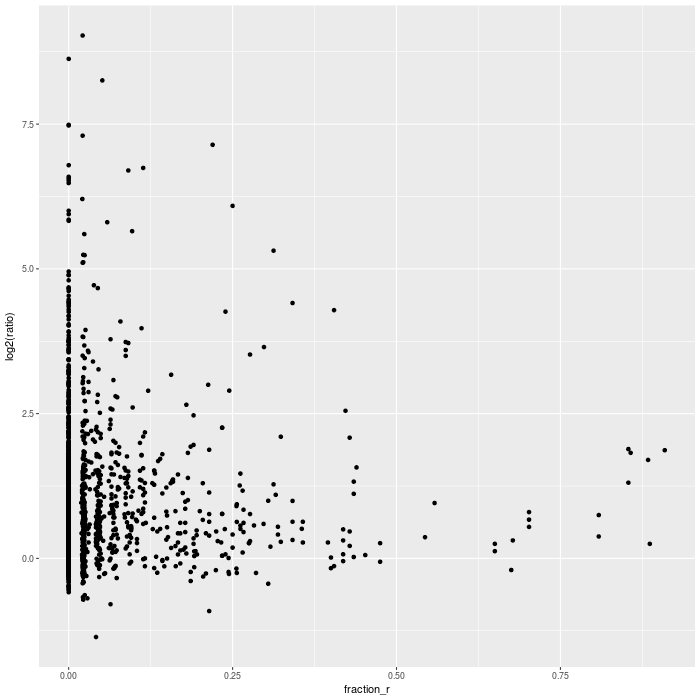

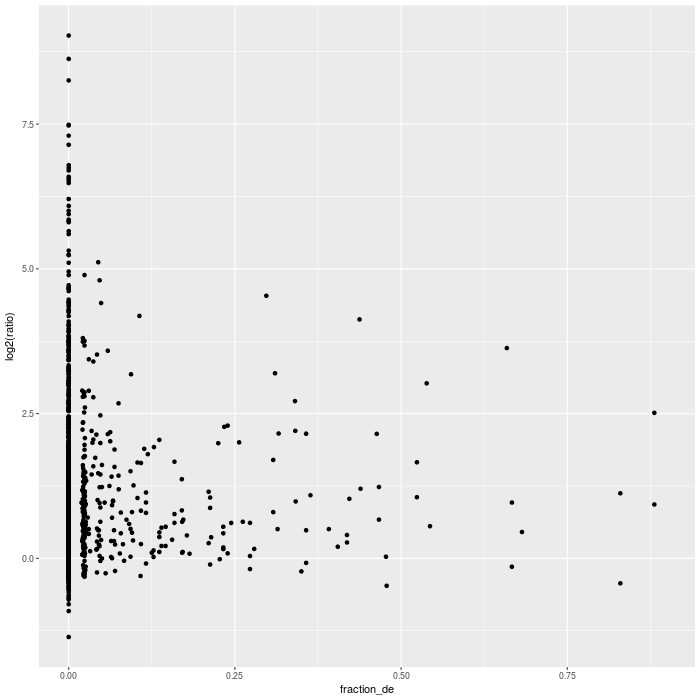

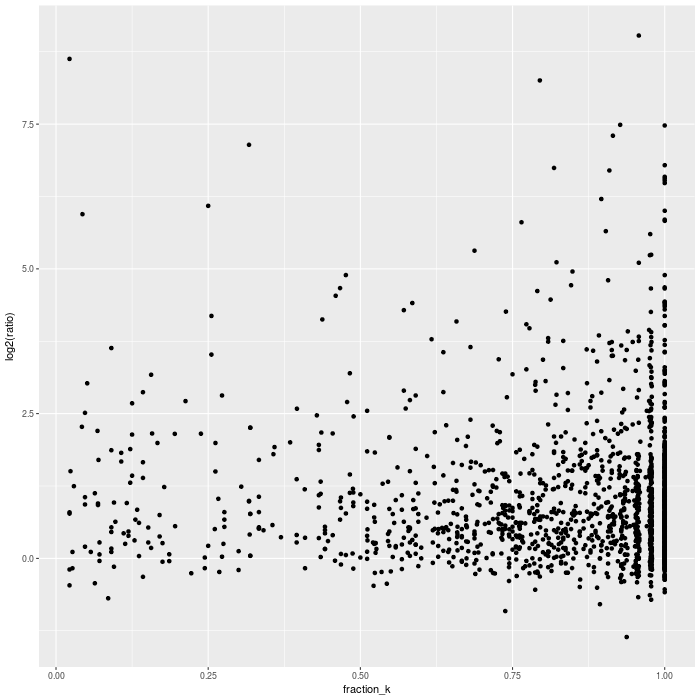

In [89]:
%%R -i df -w 700 -h 700
print(head(df))
p = ggplot(df, aes(fraction_r, log2(ratio))) + geom_point()
print(p)

p = ggplot(df, aes(fraction_de, log2(ratio))) + geom_point()
print(p)

p = ggplot(df, aes(fraction_k, log2(ratio))) + geom_point()
print(p)

  uniprot_id position succ.lysine k_mammals k_non_mammals non_k_mammals
0     P30681      127       FALSE        27            22             0
1     P30681      128        TRUE        27            19             0
2     Q91YQ5      577       FALSE        27            17             0
3     Q91YQ5      579       FALSE        27            17             0
4     Q91YQ5      580        TRUE        27            17             0
5     Q91YQ5      588       FALSE        27            17             0
  non_k_non_mammals de_mammals non_de_mammals de_non_mammals non_de_non_mammals
0                 0          0             27              0                 22
1                 0          0             27              0                 19
2                 0          0             27              0                 17
3                 0          0             27              0                 17
4                 0          0             27              0                 17
5               

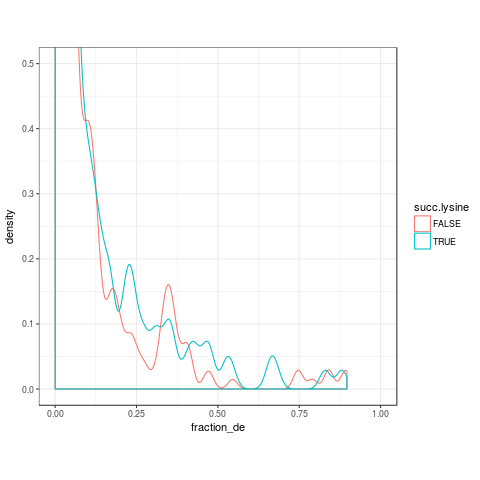

In [90]:
%%R -i df
print(head(df))
threshold = 0.1
print(table(ifelse(df$fraction_de > threshold, "de", "non_de"), df$succ.lysine))
print(fisher.test(table(ifelse(df$fraction_de > threshold, "de", "non_de"), df$succ.lysine)))


threshold = 0.1
print(table(ifelse(df$fraction_r > threshold, "r", "non_r"), df$succ.lysine))
print(fisher.test(table(ifelse(df$fraction_r > threshold, "r", "non_r"), df$succ.lysine)))


threshold = 0.05
print(table(ifelse(df$fraction_k > threshold, "k", "non_k"), df$succ.lysine))
print(fisher.test(table(ifelse(df$fraction_k > threshold, "k", "non_k"), df$succ.lysine)))


my_theme = theme(aspect.ratio=1)

p = ggplot(df, aes(col=succ.lysine, x=fraction_de))
p2 = p + geom_density() + coord_cartesian(xlim=c(0, 1), ylim=c(0,0.5)) +
theme_bw() + my_theme
                
print(p2)

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


  uniprot_id position succ.lysine k_mammals k_non_mammals non_k_mammals
0     P30681      127       FALSE        27            22             0
1     P30681      128        TRUE        27            19             0
2     Q91YQ5      577       FALSE        27            17             0
3     Q91YQ5      579       FALSE        27            17             0
4     Q91YQ5      580        TRUE        27            17             0
5     Q91YQ5      588       FALSE        27            17             0
  non_k_non_mammals de_mammals non_de_mammals de_non_mammals non_de_non_mammals
0                 0          0             27              0                 22
1                 0          0             27              0                 19
2                 0          0             27              0                 17
3                 0          0             27              0                 17
4                 0          0             27              0                 17
5               

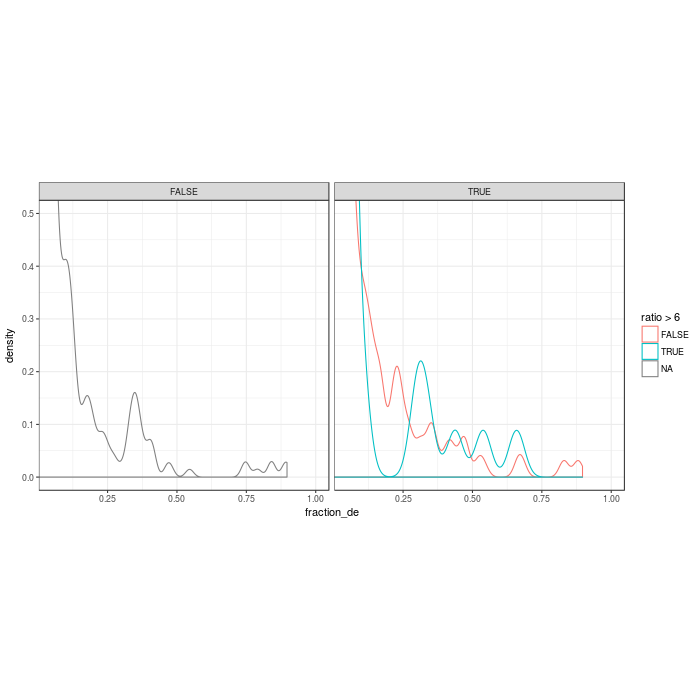

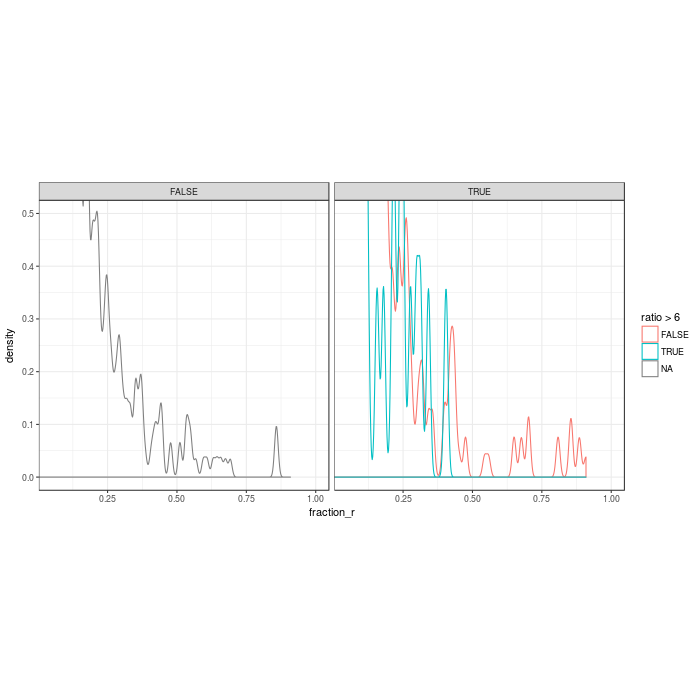

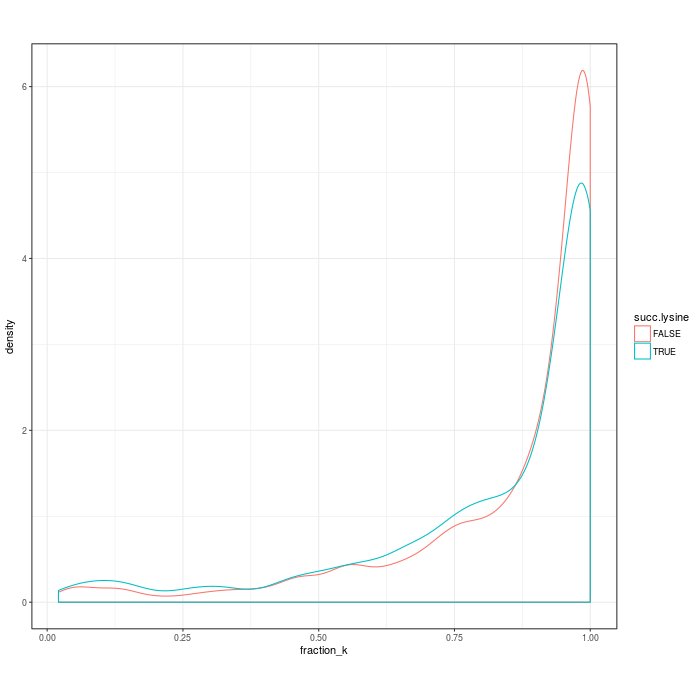

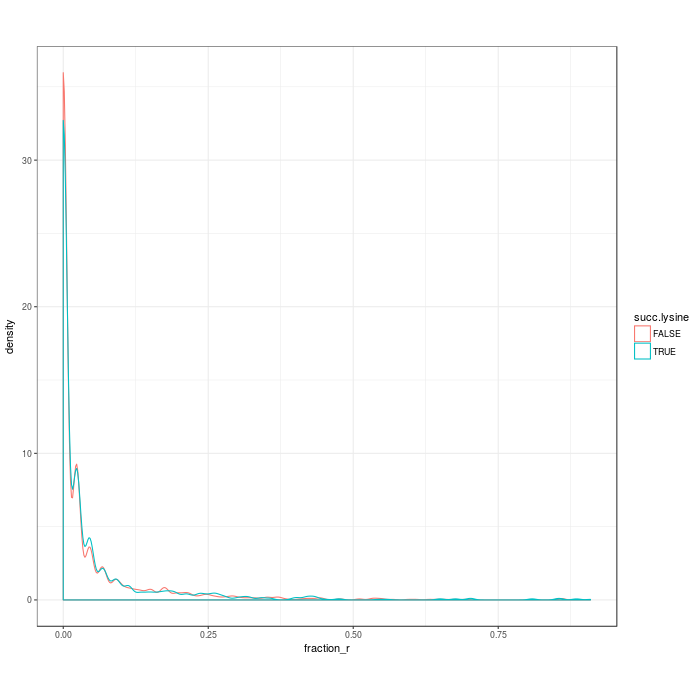

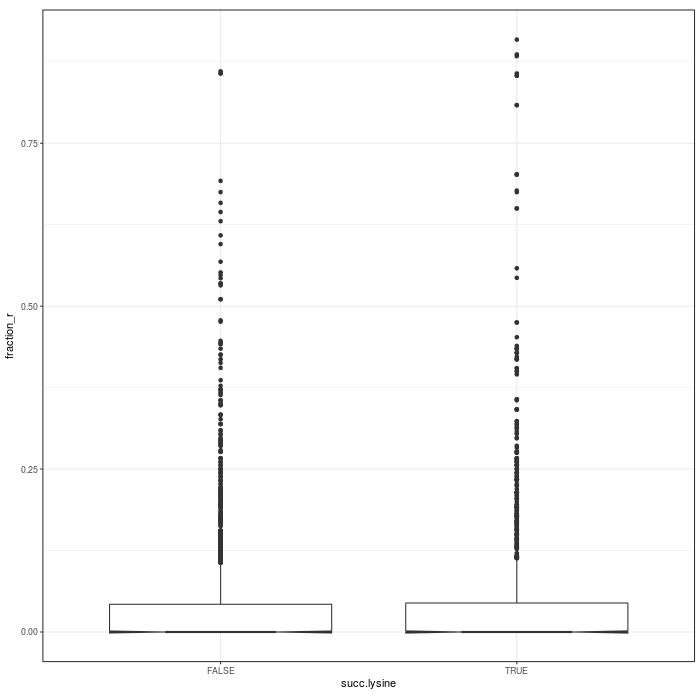

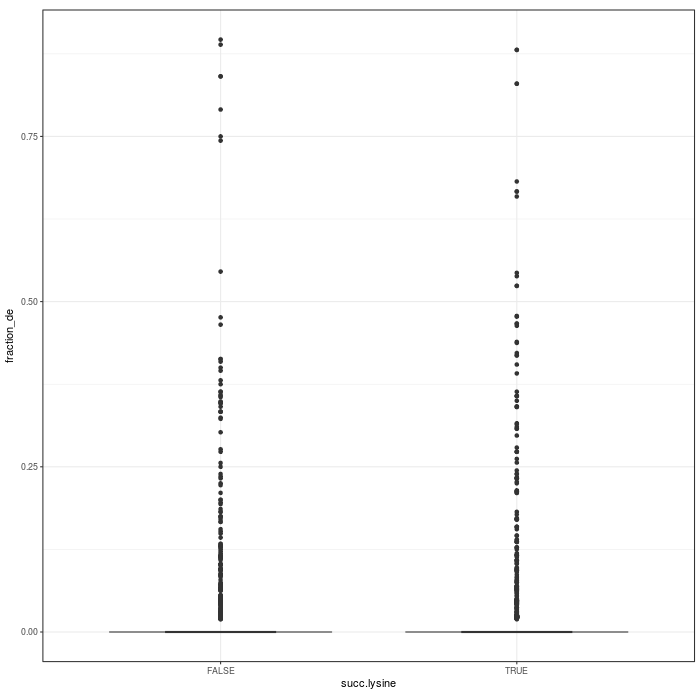

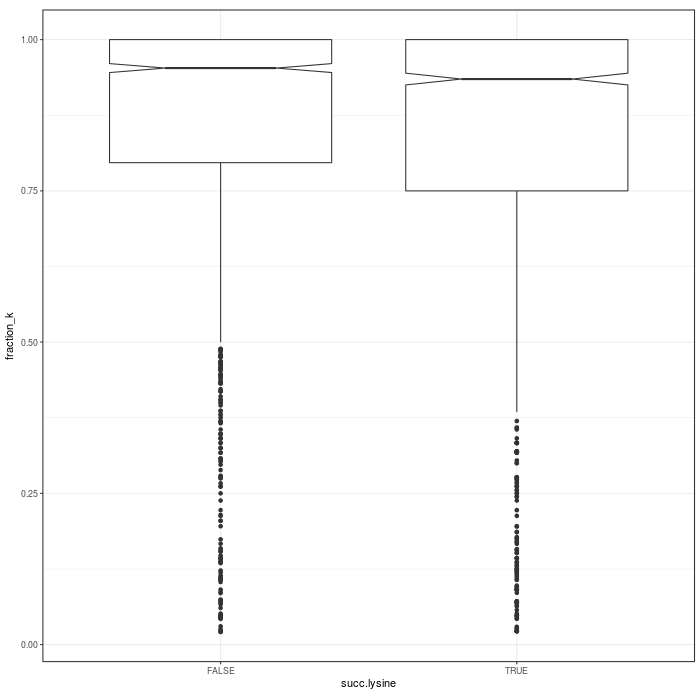

In [91]:
%%R -i df -w 700 -h 700
print(head(df))

my_theme = theme(aspect.ratio=1)

p = ggplot(df, aes(col=ratio>6, x=fraction_de))

p2 = p + geom_density() + coord_cartesian(xlim=c(0.05, 1), ylim=c(0,0.5)) + facet_wrap(~succ.lysine) +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(col=ratio>6, x=fraction_r))

p2 = p + geom_density() + coord_cartesian(xlim=c(0.05, 1), ylim=c(0,0.5)) + facet_wrap(~succ.lysine) +
theme_bw() + my_theme
                
                
print(p2)


p = ggplot(df, aes(col=succ.lysine, x=fraction_k))

p2 = p + geom_density()  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(col=succ.lysine, x=fraction_r))

p2 = p + geom_density()  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(x=succ.lysine, y=fraction_r))

p2 = p + geom_boxplot(notch=T)  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(x=succ.lysine, y=fraction_de))

p2 = p + geom_boxplot(notch=T)  +
theme_bw() + my_theme
                
print(p2)

p = ggplot(df, aes(x=succ.lysine, y=fraction_k))

p2 = p + geom_boxplot(notch=T)  +
theme_bw() + my_theme
                
print(p2)

In [92]:
#for uniprot_id in set(df['uniprot_id']):
print(outfile_aligned)
for uniprot_id in ["Q91V76"]:
    print("\n", uniprot_id)
    retained_uniprot_ids = uniprot2_121_orthologs[uniprot_id]
    
    outfile_aligned = "./results/conservation/fasta/%s_clustalo.fa" % uniprot_id
    print(outfile_aligned)
    
    for fasta in FA.iterate(IOTools.openFile(outfile_aligned, "r")):
        tax_id_uniprot_id, tax_id = fasta.title.split("_")
        tax_id = int(tax_id.replace(";", ""))
        if tax_id_uniprot_id == uniprot_id:
            mouse_seq = fasta.sequence
            bases_array_mammals = np.zeros((len(aas), len(fasta.sequence)))
            bases_array_non_mammals = np.zeros((len(aas), len(fasta.sequence)))

        if tax_id in mammal_ids:
            for ix, base in enumerate(fasta.sequence):
                bases_array_mammals[(aas.index(base), ix)] += 1
        else:
            for ix, base in enumerate(fasta.sequence):
                bases_array_non_mammals[(aas.index(base), ix)] += 1

    seq_n = 0

    for ix, base in enumerate(mouse_seq):
        if base != "-":
            seq_n += 1

        fraction_k_non_mammals = (bases_array_non_mammals[aas.index("K"),ix] /
                      (sum(bases_array_non_mammals[:,ix]) - bases_array_non_mammals[aas.index("-"),ix]))
        fraction_de_non_mammals = ((bases_array_non_mammals[aas.index("D"),ix] +
                                    bases_array_non_mammals[aas.index("E"),ix])/
                      (sum(bases_array_non_mammals[:,ix]) - bases_array_non_mammals[aas.index("-"),ix]))

        fraction_k_mammals = (bases_array_mammals[aas.index("K"),ix] /
                      (sum(bases_array_mammals[:,ix]) - bases_array_mammals[aas.index("-"),ix]))
        fraction_de_mammals = ((bases_array_mammals[aas.index("D"),ix] + bases_array_mammals[aas.index("E"),ix])/
                      (sum(bases_array_mammals[:,ix]) - bases_array_mammals[aas.index("-"),ix]))

        #print(ix, base, fraction_k, fraction_de)

        if ((fraction_de_mammals > 0.5 and fraction_de_non_mammals < 0.2) and
            (sum(bases_array_mammals[:,ix]) - bases_array_mammals[aas.index("-"),ix]) >= 10 and
            (sum(bases_array_non_mammals[:,ix]) - bases_array_non_mammals[aas.index("-"),ix]) >= 5):
            
            pass

            print(fraction_de_mammals > 0.5, fraction_de_non_mammals < 0.5)
            print(ix, seq_n, base, fraction_de_mammals, fraction_de_non_mammals)
            print(bases_array_mammals[aas.index("D"),ix], bases_array_non_mammals[aas.index("D"),ix])
            print(bases_array_mammals[aas.index("E"),ix], bases_array_non_mammals[aas.index("E"),ix])
            print(print(bases_array_mammals[aas.index("E"),ix], bases_array_non_mammals[aas.index("E"),ix]))
            

            species = set()
            tmp_alignments = ""
            for fasta in FA.iterate(IOTools.openFile(outfile_aligned, "r")):
                tax_id_uniprot_id, tax_id = fasta.title.split("_")
                tax_id = int(tax_id.replace(";", ""))
                if tax_id_uniprot_id in retained_uniprot_ids or tax_id_uniprot_id == uniprot_id:
                    species.add(tax_id)
                    tmp_alignments += ">%i\n%s\n" % (tax_id, fasta.sequence[ix-10: ix+10])

            tree = ncbi.get_topology(species, intermediate_nodes=False)
            tree.link_to_alignment(tmp_alignments)
            
            #tree.show()
                
            
            

./results/conservation/fasta/Q91WN4_clustalo.fa

 Q91V76
./results/conservation/fasta/Q91V76_clustalo.fa


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [93]:
n = 0 

mammal_ids = set()
non_mammal_ids = set()

rows = []

for uniprot_id in alignments.keys():

    for position in alignments[uniprot_id]:
   
        k_organisms = amino_acids_at_K[uniprot_id][position]["K"]
        r_organisms = amino_acids_at_K[uniprot_id][position]["R"]
        de_organisms = amino_acids_at_K[uniprot_id][position]["D"]
        de_organisms.update(amino_acids_at_K[uniprot_id][position]["E"])
        organisms = set()
        for aa in aas:
            if aa != "-":
                organisms.update(amino_acids_at_K[uniprot_id][position][aa])
        non_k_organisms = organisms.difference(k_organisms)
        non_de_organisms = organisms.difference(de_organisms)
        non_r_organisms = organisms.difference(r_organisms)

        k_mammals = []
        k_non_mammals = []
        for x in k_organisms:
            if x in mammal_ids:
                k_mammals.append(x)
            elif x in non_mammal_ids:
                k_non_mammals.append(x)
            else:
                if isInGroup(x, mammals_tax_id):
                    k_mammals.append(x)
                    mammal_ids.add(x)
                else:
                    k_non_mammals.append(x)
                    non_mammal_ids.add(x)

        non_k_mammals = []
        non_k_non_mammals = []
        for x in non_k_organisms:
            if x in mammal_ids:
                non_k_mammals.append(x)
            elif x in non_mammal_ids:
                non_k_non_mammals.append(x)
            else:
                if isInGroup(x, mammals_tax_id):
                    k_mammals.append(x)
                    mammal_ids.add(x)
                else:
                    k_non_mammals.append(x)
                    non_mammal_ids.add(x)   
  
        de_mammals = []
        de_non_mammals = []
        for x in de_organisms:
            if x in mammal_ids:
                de_mammals.append(x)
            elif x in non_mammal_ids:
                de_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here!")
        
        r_mammals = []
        r_non_mammals = []
        for x in r_organisms:
            if x in mammal_ids:
                r_mammals.append(x)
            elif x in non_mammal_ids:
                r_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here!")
                
        non_k_mammals = []
        non_k_non_mammals = []
        for x in non_k_organisms:
            if x in mammal_ids:
                non_k_mammals.append(x)
            elif x in non_mammal_ids:
                non_k_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here!")

        non_de_mammals = []
        non_de_non_mammals = []
        for x in non_de_organisms:
            if x in mammal_ids:
                non_de_mammals.append(x)
            elif x in non_mammal_ids:
                non_de_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here2!")

        non_r_mammals = []
        non_r_non_mammals = []
        for x in non_r_organisms:
            if x in mammal_ids:
                non_r_mammals.append(x)
            elif x in non_mammal_ids:
                non_r_non_mammals.append(x)
            else:
                raise ValueError("shouldn't reach here2!")
                
        if (len(k_non_mammals) + len(non_k_non_mammals)) == 0:
            print("No non mammals!", uniprot_id, position)
            continue

        fraction_k_mammal = (len(k_mammals) / ( len(non_k_mammals) + len(k_mammals)))
        fraction_k_non_mammal = (len(k_non_mammals) / ( len(non_k_non_mammals) + len(k_non_mammals)))

        fraction_de_mammal = (len(de_mammals) / ( len(non_de_mammals) + len(de_mammals)))
        fraction_de_non_mammal = (len(de_non_mammals) / ( len(non_de_non_mammals) + len(de_non_mammals)))

        fraction_r_mammal = (len(r_mammals) / ( len(non_r_mammals) + len(r_mammals)))
        fraction_r_non_mammal = (len(r_non_mammals) / ( len(non_r_non_mammals) + len(r_non_mammals)))
        
        row = [uniprot_id, position,
               fraction_k_mammal, fraction_k_non_mammal,
               fraction_de_mammal, fraction_de_non_mammal,
               fraction_r_mammal, fraction_r_non_mammal]
        
        tree = ncbi.get_topology(organisms, intermediate_nodes=False)
        tree.link_to_alignment(alignments[uniprot_id][position])
        #tree.show()
            
        if fraction_k_mammal > 0.8 and fraction_de_non_mammal > 0.4:
            row.append(1)
            print(uniprot_id, position)
            print(fraction_k_mammal)
            print(fraction_de_non_mammal)
            
            try:
                tree = ncbi.get_topology(k_organisms, intermediate_nodes=False)

                #print(dir(tree))
                #print(type(tree))
                print(tree.taxid)
                print(ncbi.translate_to_names([tree.taxid]))
                print(ncbi.get_common_names([tree.taxid]))
                ##print(tree.get_ascii(attributes=["sci_name", "rank"]))
            except:
                pass

            tree = ncbi.get_topology(organisms, intermediate_nodes=False)
            tree.link_to_alignment(alignments[uniprot_id][position])
            #tree.show()
            n+=1
            #tree.render("./results/conservation/plots/%s_%s.png" % (uniprot_id, position))
            #raise ValueError()
        else:
            row.append(0)
            
        if fraction_k_mammal > 0.8 and fraction_k_non_mammal < 0.2:
            row.append(1)
        else:
            row.append(0)

        rows.append(row)

Q9D0K2 185
0.9230769230769231
0.5789473684210527
8287
['Sarcopterygii']
{}
No non mammals! Q91VA0 352
No non mammals! Q91VA0 545
No non mammals! Q91VA0 387
No non mammals! Q91VA0 324
No non mammals! Q91VA0 534
No non mammals! Q91VA0 200
No non mammals! Q91VA0 249
No non mammals! Q91VA0 252
No non mammals! Q91VA0 541
No non mammals! Q91VA0 142
No non mammals! Q91VA0 527
Q9DCY0 140
0.8518518518518519
1.0
32525
['Theria']
{}
No non mammals! Q9DCY0 150
Q8QZS1 296
0.9615384615384616
0.8888888888888888
32525
['Theria']
{}
Q8QZS1 364
0.8695652173913043
0.8888888888888888
9347
['Eutheria']
{9347: 'placentals'}
No non mammals! P47915 112
No non mammals! P47915 145
No non mammals! P47915 151
No non mammals! P47915 134
P25688 126
0.8181818181818182
0.47619047619047616
8287
['Sarcopterygii']
{}
P09411 361
0.8888888888888888
1.0
9347
['Eutheria']
{9347: 'placentals'}


Duplicated entry [9940] was renamed to [1_9940]


Q99KE1 240
0.8461538461538461
0.9285714285714286
9347
['Eutheria']
{9347: 'placentals'}
Q9EQ20 376
1.0
0.5789473684210527
7742
['Vertebrata']
{7742: 'vertebrates'}
Q9EQ20 55
1.0
0.9375
32525
['Theria']
{}
Q925I1 494
0.9565217391304348
0.5294117647058824
32524
['Amniota']
{32524: 'amniotes'}
No non mammals! Q91XE0 161
No non mammals! Q91XE0 151
Q9QXD1 66
0.8461538461538461
1.0
32525
['Theria']
{}
Q5FW57 43
0.8518518518518519
1.0
9347
['Eutheria']
{9347: 'placentals'}
Q5FW57 183
0.8888888888888888
0.5
117571
['Euteleostomi']
{117571: 'bony vertebrates'}
P16045 29
0.9230769230769231
0.47368421052631576
32523
['Tetrapoda']
{32523: 'tetrapods'}
P19324 290
0.9615384615384616
0.42105263157894735
32523
['Tetrapoda']
{32523: 'tetrapods'}
P16332 593
0.8076923076923077
0.9473684210526315
9347
['Eutheria']
{9347: 'placentals'}


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:224: UserWarning: taxid 994 was translated into 986
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
Warnning: [1] terminal nodes could not be found in the alignment.
Warnning: [1] terminal nodes could not be found in the alignment.


No non mammals! P03930 48
No non mammals! P03930 46
No non mammals! P03930 54
Q9DCS3 61
0.9583333333333334
0.5625
117571
['Euteleostomi']
{117571: 'bony vertebrates'}
Q8BH95 43
0.88
0.6470588235294118
40674
['Mammalia']
{40674: 'mammals'}
Q9R0H0 216
0.9615384615384616
0.6666666666666666
40674
['Mammalia']
{40674: 'mammals'}
Q9DCW4 116
1.0
0.6153846153846154
40674
['Mammalia']
{40674: 'mammals'}


Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]


Q9D6Y7 104
0.9583333333333334
0.5
117571
['Euteleostomi']
{117571: 'bony vertebrates'}
Q8BMF4 461
0.9230769230769231
0.4444444444444444
8287
['Sarcopterygii']
{}
Q921H8 234
0.9230769230769231
0.5294117647058824
32525
['Theria']
{}
Q9DBM2 248
0.8461538461538461
0.4444444444444444
117571
['Euteleostomi']
{117571: 'bony vertebrates'}


In [108]:
header = ["uniprot_id", "position",
          "fraction_k_mammal", "fraction_k_non_mammal",
          "fraction_de_mammal", "fraction_de_non_mammal",
          "fraction_r_mammal", "fraction_r_non_mammal",
          'succ._dep._charge', 'mammal_specific_k']

conservation_changes_df = pd.DataFrame.from_records(rows, columns = header)
conservation_changes_df = pd.merge(
    conservation_changes_df, ratio_df,
    left_on=["uniprot_id", "position"], right_on=["uniprot_id", "position"],
    how='left')
conservation_changes_df.drop('in_elm', axis=1, inplace=True)
print(conservation_changes_df.head())
conservation_changes_df.to_csv("./results/conservation/change_df.tsv",sep="\t", index=False)

  uniprot_id  position  fraction_k_mammal  fraction_k_non_mammal  \
0     P30681       128                1.0                 0.8800   
1     Q91YQ5       580                1.0                 1.0000   
2     Q91YQ5       539                1.0                 1.0000   
3     Q91YQ5       188                1.0                 1.0000   
4     P70168       541                1.0                 0.9375   

   fraction_de_mammal  fraction_de_non_mammal  fraction_r_mammal  \
0                 0.0                     0.0                0.0   
1                 0.0                     0.0                0.0   
2                 0.0                     0.0                0.0   
3                 0.0                     0.0                0.0   
4                 0.0                     0.0                0.0   

   fraction_r_non_mammal  succ._dep._charge  mammal_specific_k   modification  \
0               0.136364                  0                  0  succinylation   
1               0.00

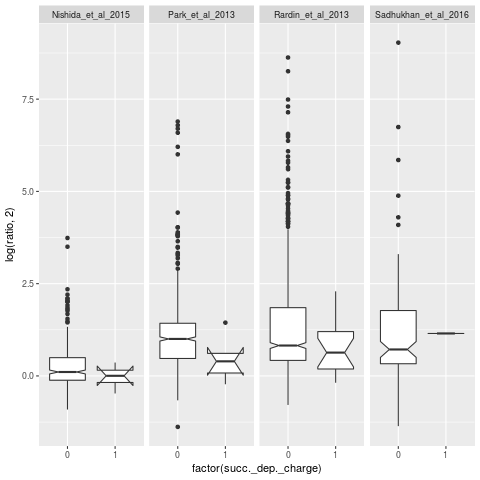

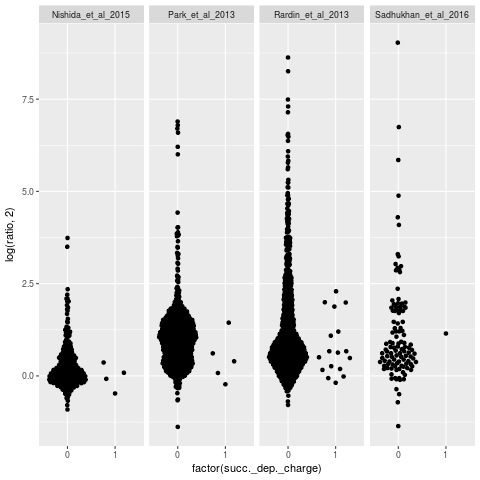

In [113]:
%%R -i conservation_changes_df
library(ggplot2)

df <- conservation_changes_df[order(-conservation_changes_df$succ._dep._charge),]

p = ggplot(df, aes(factor(succ._dep._charge), log(ratio, 2))) +
facet_grid(.~reference)

p2 = p + geom_boxplot(notch=T)
print(p2)

p2 = p + geom_quasirandom()
print(p2)




In [96]:
%%R
tmp_df = df[df$reference=='Rardin_et_al_2013',]
print(table(tmp_df$p_value<0.001, tmp_df$mammal_specific_k))
print(table(tmp_df$p_value<0.001, tmp_df$succ._dep._charge))
print(table(tmp_df$p_value<0.001, tmp_df$fraction_k_non_mammal>0.7))

       
          0   1
  FALSE 457  36
  TRUE  317  28
       
          0   1
  FALSE 481  12
  TRUE  340   5
       
        FALSE TRUE
  FALSE   218  275
  TRUE    137  208


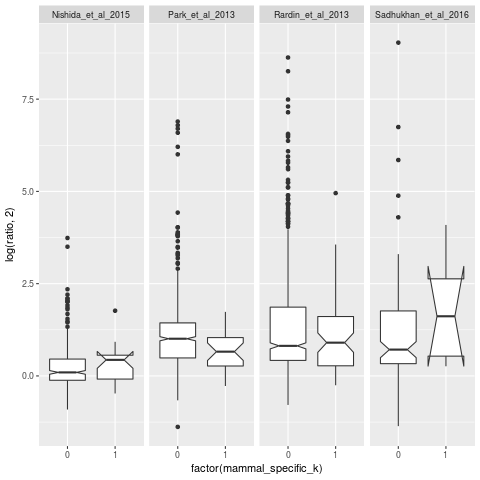

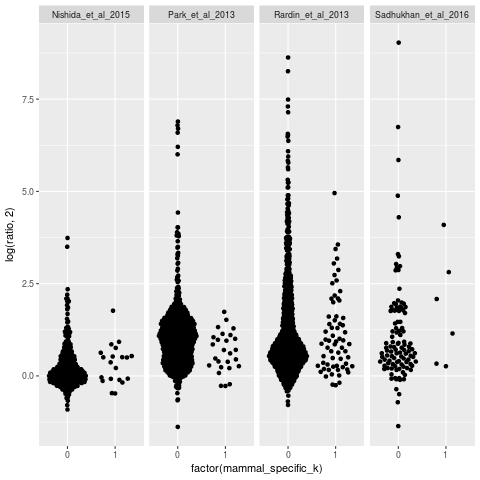

In [97]:
%%R
p = ggplot(df, aes(factor(mammal_specific_k), log(ratio, 2))) +
facet_grid(.~reference)

p2 = p + geom_boxplot(notch=T)
print(p2)

p2 = p + geom_quasirandom()
print(p2)

In [98]:
# show a specific uniprot id and position tree + alignment

uniprot_id = 'Q9D0K2'
position = 185

k_organisms = amino_acids_at_K[uniprot_id][position]["K"]       

organisms = set()
for aa in aas:
    if aa != "-":
        organisms.update(amino_acids_at_K[uniprot_id][position][aa])

non_k_organisms = organisms.difference(k_organisms)

tree = ncbi.get_topology(organisms, intermediate_nodes=False)
tree.link_to_alignment(alignments[uniprot_id][position])
n+=1
#tree.show()


In [99]:
n = 0 
for uniprot_id in alignments.keys():
    #print(uniprot_id)
    for position in alignments[uniprot_id]:
        k_organisms = amino_acids_at_K[uniprot_id][position]["K"]       
        organisms = set()
        for aa in aas:
            if aa != "-":
                organisms.update(amino_acids_at_K[uniprot_id][position][aa])
        non_k_organisms = organisms.difference(k_organisms)
        
        tree = ncbi.get_topology(organisms, intermediate_nodes=False)
        tree.link_to_alignment(alignments[uniprot_id][position])

        tree.render("./results/conservation/plots/%s_%s.png" % (uniprot_id, position), )
        
        n+=1
        if n%20==0:
            print(n)


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400


Duplicated entry [9940] was renamed to [1_9940]


420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880


Warnning: [1] terminal nodes could not be found in the alignment.
Warnning: [1] terminal nodes could not be found in the alignment.


900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140


Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]
Duplicated entry [7955] was renamed to [1_7955]
Duplicated entry [9598] was renamed to [1_9598]


1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
